![digitizing_team](digitizing_team.png)


DigiNsure Inc. is an innovative insurance company focused on enhancing the efficiency of processing claims and customer service interactions. Their newest initiative is digitizing all historical insurance claim documents, which includes improving the labeling of some IDs scanned from paper documents and identifying them as primary or secondary IDs.

To help them in their effort, you'll be using multi-modal learning to train an Optical Character Recognition (OCR) model. To improve the classification, the model will use **images** of the scanned documents as input and their **insurance type** (home, life, auto, health, or other). Integrating different data modalities (such as image and text) enables the model to perform better in complex scenarios, helping to capture more nuanced information. The **labels** that the model will be trained to identify are of two types: a primary and a secondary ID, for each image-insurance type pair.

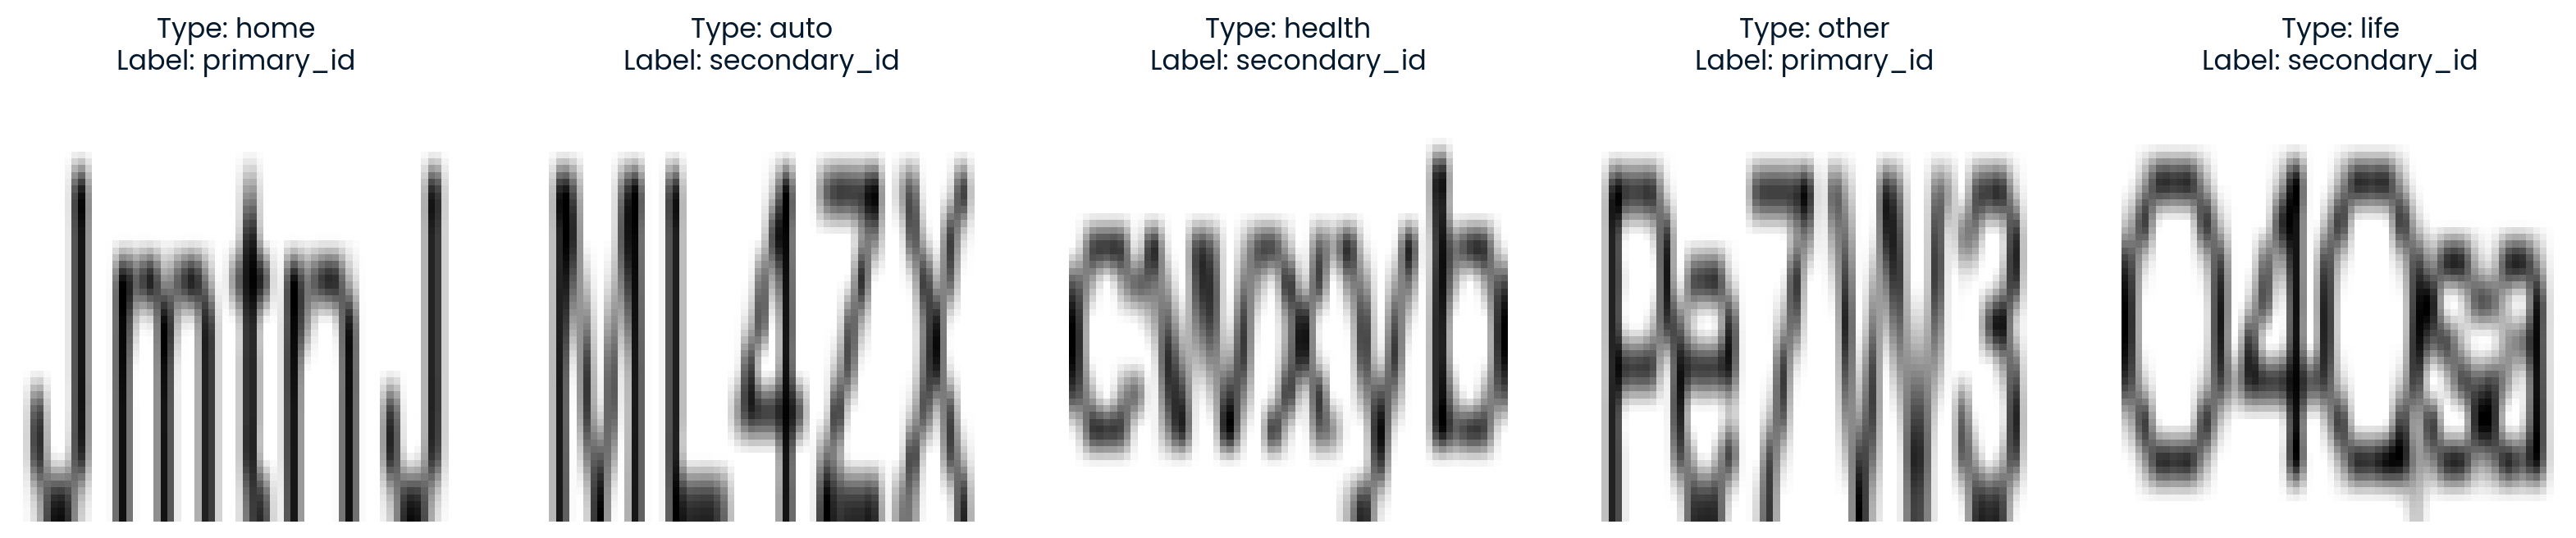

In [41]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from project_utils import ProjectDataset
import pickle 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Load the data
dataset = pickle.load(open('ocr_insurance_dataset.pkl', 'rb'))

# Define a function to visualize codes with their corresponding types and labels 
def show_dataset_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, min(num_images, len(dataset)), figsize=(20, 4))
    for ax, idx in zip(axes, np.random.choice(len(dataset), min(num_images, len(dataset)), False)):
        img, lbl = dataset[idx]
        ax.imshow((img[0].numpy() * 255).astype(np.uint8).reshape(64,64), cmap='gray'), ax.axis('off')
        ax.set_title(f"Type: {list(dataset.type_mapping.keys())[img[1].tolist().index(1)]}\nLabel: {list(dataset.label_mapping.keys())[list(dataset.label_mapping.values()).index(lbl)]}")
    plt.show()

# Inspect 5 codes images from the dataset
show_dataset_images(dataset)

In [ ]:
dataset_loader = DataLoader(dataset, batch_size=3, shuffle=True)

In [43]:
class OCRModel(nn.Module):
    def __init__(self):
        super(OCRModel, self).__init__()
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(32*16*16, 128)
        )
        self.text_layer = nn.Sequential(
            nn.Linear(5, 10),
            nn.ELU()
        )
        self.classifer = nn.Sequential(
            nn.Linear(128 + 10, 64),
            nn.ELU(),
            nn.Linear(64, 2)
        )

    def forward(self, x_image, x_alphabet):
        x_image = self.image_layer(x_image)
        x_alphabet = self.text_layer(x_alphabet)
        x = torch.cat((x_image, x_alphabet), dim=1)
        return self.classifer(x)

In [44]:
model = OCRModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [45]:
for epoch  in range(10):
    for (image, types), label in dataset_loader:
        optimizer.zero_grad()
        output = model(image, types)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.744936466217041
Epoch 2, Loss: 0.9367356300354004
Epoch 3, Loss: 0.796104907989502
Epoch 4, Loss: 1.6704336404800415
Epoch 5, Loss: 1.0812610387802124
Epoch 6, Loss: 0.007116091437637806
Epoch 7, Loss: 0.0022053224965929985
Epoch 8, Loss: 6.353653589030728e-05
Epoch 9, Loss: 0.1659136712551117
Epoch 10, Loss: 0.17301657795906067
